# Empirical Data Analysis

We introduce a novel technique to extrapolate/predict the expected number of coverage elements to discover in a fuzzing campaign, if we continue the campaign a bit further.

* **Experiments -** We ran the state-of-the-art greybox fuzzer, AFL++ on multiple subject programs with various number of LoC.

* **Analysis -** In this notebook, we present our novel algorithm on obtained fuzzing data and evaluation of the results against the existing extrapolation technique.


In [2]:
#Required libraries
library(rjson)
library(stringr)
library(jsonlite)
library(ggplot2)
library(dplyr)
library(tidyverse)
library(scales)
library(grid)
library(gridExtra)
library(tidyr)
library(plotly)
library(foreach)
library(doParallel)
library(cowplot)
library(lsr)
library(rstatix)
library(colorspace)

REGENERATE_DATA = FALSE

options(warn=-1) # Supress irrelevant warnings

## Extrapolate coverage for real-world programs

In [3]:
alp = 0.3 # Alpha parameter
if(REGENERATE_DATA){
    
    unzip("../data/fuzztastic_data.zip",exdir="../data/")
    
    subjects = list.files("../data/fuzztastic_data/")
    
    RESET = TRUE
    sub1 = 1
    sub2 = 1
    n_reps = 5
    for(subject in subjects){
        folder = paste("../data/fuzztastic_data/",subject,"/","seed_01",sep="")
        for(file_run in list.files(folder)){
            data = tibble()
            subject = subject
            run = str_sub(file_run,-2)
            timestamps = c()
            n_list = c()
            sn_list = c()
            f1_list = c()
            f2_list = c()
            u_list = c()
            for(file in list.files(paste(folder,"/",file_run,sep=""))){
                ## Prepare the hit count table using all the available data
                bb_cov = as.data.frame(fromJSON(paste(folder,"/",file_run,"/",file,sep="")))
                bb_cov = bb_cov %>% mutate(block_coverage = ifelse(block_coverage>=8,block_coverage-8,block_coverage)) # 8 calibration runs.
                temp = t(as.data.frame(bb_cov$block_coverage))
                colnames(temp) = 1:length(bb_cov$block_coverage)
                row.names(temp) = NULL
                temp = as.data.frame(temp)
                timestamps = c(timestamps,as.integer(substr(str_split(file,"_")[[1]][3],1,10)))
                n_list = c(n_list,max(bb_cov$block_coverage))
                sn_list = c(sn_list,sum((bb_cov$block_coverage)>0))
                data = rbind(data,temp)
            }
            bb_ids = 1:length(bb_cov$block_coverage)
            transformed = data %>% summarise(across(1:length(bb_ids),function(x) cumsum(c(0,ifelse(diff(x)>0,1,0)))))
            f1_list = apply(transformed,1,function(x) sum(as.numeric(unlist(x))==1))
            f2_list = apply(transformed,1,function(x) sum(as.numeric(unlist(x))==2))
            u_list = rowSums(transformed)
            gb_df = tibble(subject=subject,run=run,timestamp=timestamps,n=n_list,theta=0:length(n_list[-1]),
                           u=u_list,f1=f1_list,f2=f2_list,sn_gb=sn_list)
            ## Write gb_data
            if(sub1==1){
               write.table(gb_df, file = "../data/gb_data.csv", row.names = FALSE,quote = FALSE)  
               sub1 = sub1 + 1
            }else{
               write.table(gb_df, file = "../data/gb_data.csv",
                append = TRUE, quote = FALSE,
                col.names = FALSE, row.names = FALSE)
            }
            
            transformed = data %>% summarise(across(1:length(bb_ids),function(x) ifelse(diff(x)>0,1,0)))
            timestamps = timestamps[-1]
            n_list = n_list[-1]
            u_list = u_list[-1]
            sn_list = sn_list[-1]
            f1_list = f1_list[-1]
            f2_list = f2_list[-1]
            
            for(m in seq(1,length(u_list),4)){
                dis_prob = tibble()
                cores = detectCores()
                cl = makeCluster(cores[1]-1,type = "FORK")
                registerDoParallel(cl)
                ## Shuffling algorithm (difference, shuffle, reconstitute) for selected theta0
                ## Do the estimates for all X = theta0-k where 0<k<theta0 after the shuffling algorithm
                ## To get more estimates, repeat this several times (i.e. # of repetitions)
                dis_prob = foreach(rep=1:n_reps, .combine='rbind', .packages=c("dplyr", "tidyverse")) %dopar% {
                   filtered = transformed %>% mutate(theta=1:n()) %>% filter(theta<=m)
                   if(RESET){
                       cut_pt = round(exp(seq(log(1),log(m),length=11))[(10*(1-alp)+1)])
                       filtered = filtered %>% filter(theta>=cut_pt)
                   }else{
                       cut_pt = 0
                   }
                   theta_list = filtered$theta
                   filtered = filtered %>% select(-theta)
                   shuffle_order = sample(1:nrow(filtered),nrow(filtered))
                   filtered = filtered[shuffle_order,]
                   filtered = filtered %>% summarise(across(1:length(bb_ids),cumsum))
                   f1 = apply(filtered,1,function(x) sum(as.numeric(unlist(x))==1))
                   f2 = apply(filtered,1,function(x) sum(as.numeric(unlist(x))==2))
                   sn = apply(filtered,1,function(x) sum(as.numeric(unlist(x))>0))
                   rm(list = c("filtered"))
                   tibble(subject=subject,alpha=alp,run=run,repetition=rep,timestamp=timestamps[m],
                          time=timestamps[cut_pt:m],n0=n_list[m],n=n_list[cut_pt:m],theta=theta_list,
                          start=cut_pt,theta0=m,f1=f1+1,f2=f2+1,
                          gt = (f1/(theta-start))*(((theta-start-1)*f1)/((theta-start-1)*f1+(2*f2))),
                          sn=sn,s=length(bb_ids))
                }
                
                if(sub2==1){
                    write.table(dis_prob, file = "../data/bb_data.csv", row.names = FALSE,quote = FALSE)
                    sub2 = sub2 + 1
                }else{
                    write.table(dis_prob, file = "../data/bb_data.csv",
                    append = TRUE, quote = FALSE,
                    col.names = FALSE, row.names = FALSE)
                }
                stopCluster(cl)
                gc()
            }
        }
    }
    ## Save gathered data as R objects for future use
    gb_data = read.table("../data/gb_data.csv",header=T)
    gb_data$run = as.factor(gb_data$run)
    
    gb_data = gb_data %>%
                rename(f1_gb=f1,f2_gb=f2) %>% 
                mutate(f1_gb = f1_gb + 1, f2_gb = f2_gb + 1)
    save(gb_data,file="../data/gb_data.Rdata")
    
    bb_data = read.table("../data/bb_data.csv",header=T)
    # Remove infinite values from extrapolated data table
    bb_data = bb_data %>% filter_all(all_vars(!is.infinite(.)))
    bb_data$run = as.factor(bb_data$run)
    
    # Attach greybox data to shuffling data
    bb_data = merge(bb_data,gb_data %>% select(subject,run,timestamp,f1_gb,f2_gb,sn_gb),
                    by=c("subject","run","timestamp"),all.x = TRUE)
    bb_data = bb_data %>% filter(gt > 0)
    
    # Since bb_data is a very large table, we slipt it to 3 smaller data frames and save
    bb_data_1 = bb_data %>% filter(subject %in% unique(gb_data$subject)[1:2])
    save(bb_data_1,file="../data/bb_data_1.Rdata")
    bb_data_2 = bb_data %>% filter(subject %in% unique(gb_data$subject)[3:4])
    save(bb_data_2,file="../data/bb_data_2.Rdata")
    bb_data_3 = bb_data %>% filter(subject %in% unique(gb_data$subject)[5])
    save(bb_data_3,file="../data/bb_data_3.Rdata")
    
    # Remove obsolete data frames
    rm(list = c("bb_data_1","bb_data_2","bb_data_3"))
} else{
    ## Loading saved data
    load(file="../data/gb_data.Rdata")
    load(file="../data/bb_data_1.Rdata")
    load(file="../data/bb_data_2.Rdata")
    load(file="../data/bb_data_3.Rdata")
    
    # Combine bb_data to a single data frame
    bb_data = rbind(bb_data_1,bb_data_2,bb_data_3)
    # Remove obsolete data frames
    rm(list = c("bb_data_1","bb_data_2","bb_data_3"))
    
}                       


### Perform extrapolation using novel and existing techniques

We perform linear extrapolation based on our proposed appeoach using the populated coverage rate estimates for historical data. Also we predict the coverage rates using existing technique as well.

In [4]:
## Perform Extrapolation
bet = 0.5 # beta parameter
if(REGENERATE_DATA){
    
    ## Existing extrapolator
    hat_snm = function(f1,f2,theta,m){
        f0_hat = ifelse(f2!=0,((theta-1)/(theta))*((f1^2)/(2*f2)),((theta-1)/(theta))*((f1*(f1-1))/(2)))
        est = f0_hat*(1-((1-(f1/(theta*f0_hat+f1)))^m)) - f0_hat*(1-((1-(f1/(theta*f0_hat+f1)))^(m-1)))
        est = ifelse(is.nan(est),0,est)
        return(est)
    }

    ########################################
    # Filter a random run
    init = 1
    train_data = tibble()
    t0_list = seq(50,max(gb_data$theta),by=50)
    subjects = unique(gb_data$subject)
    proportions = c(0.5,0.75,1,1.5,2,3)
    for(sub in subjects){
        for(trial in unique(bb_data$run)){
            # Filter required data
            bb_df = bb_data %>% filter(run==trial) %>% filter(subject==sub) %>% filter(theta>=round(theta0*(1-bet)))
            gb_df = gb_data %>% filter(run==trial) %>% filter(subject==sub)
            for(t0 in t0_list){
                
                ######################################
                reg_df = bb_df %>% filter(theta0<=t0)
                
                tryCatch({
                # Only to get most recent points as training
                train_limit = exp(seq(log(min((reg_df %>% filter(theta>0))$theta)),
                                      log(max((reg_df %>% filter(theta>0))$theta0)),length=11))[(10*(1-gam)+1)]
                reg_df = reg_df %>% arrange(theta) %>% filter(theta>=train_limit)
        
                reg_df[is.na(reg_df) | reg_df == "Inf"] = NA
                #reg_df = reg_df %>% mutate(gt=replace(gt,gt==0,NA))
                reg_df = reg_df %>% drop_na()
                model = lm(log(gt)~log(theta),data = reg_df)
                slope = model$coefficient[2]
                intercept = model$coefficient[1]
                
                ######################################
                predict_df = (gb_df %>% arrange(theta) %>% filter(theta>=max(reg_df$theta)))
                #predict_df = predict_df %>% mutate(gt_gb=f1_gb/theta)
                f1_gb = predict_df$f1_gb[1]
                f2_gb = predict_df$f2_gb[1]
                theta0 = predict_df$theta[1]
                #u0 = predict_df$u[1]
                extra_df = tibble()
                for(prop in proportions){
                    m = round(prop*t0)
                    if(nrow(predict_df)<m){
                    m = nrow(predict_df)
                    }
                    delta_existing=as.numeric(lapply(1:m, function(x) hat_snm(f1_gb,f2_gb,theta0,x)))
                    delta_new=as.numeric(lapply(1:m, function(x) exp((slope*log(theta0+x)+intercept))))
                                                
                    extra_df = rbind(extra_df,
                                     tibble(subject=sub,alpha=alp,beta=bet,gamma=gam,run=trial,theta0=t0,prop=prop,
                                            theta=seq(max(reg_df$theta),length=m),
                                            delta_existing=delta_existing,delta_new=delta_new,
                                            sn_gb=predict_df$sn_gb[1:m]))
                            
                }
                                         
                if(init==1){
                   write.table(extra_df, file = "../data/extrapolated.csv", row.names = FALSE,quote = FALSE)
                   init = init + 1
                }else{
                   write.table(extra_df, file = "../data/extrapolated.csv",
                   append = TRUE, quote = FALSE,
                   col.names = FALSE, row.names = FALSE)
                }
                                             
                train_data = rbind(train_data,reg_df)
                
                }, error=function(e){})
            }
        }
    }
    ## Save gathered data as R objects for future use
    extrapolated = read.table("../data/extrapolated.csv",header=T)
    save(extrapolated,file="../data/extrapolated.Rdata")

    save(train_data,file="../data/train_data.Rdata")
    
    # Since train_data is a very large table, we slipt it to 6 smaller data frames and save them
    train_data_1 = train_data %>% filter(subject %in% subjects[1],run %in% c(1:15))
    save(train_data_1,file="../data/train_data_1.Rdata")
    train_data_2 = train_data %>% filter(subject %in% subjects[1],run %in% c(16:30))
    save(train_data_2,file="../data/train_data_2.Rdata")
    train_data_3 = train_data %>% filter(subject %in% subjects[2])
    save(train_data_3,file="../data/train_data_3.Rdata")
    train_data_4 = train_data %>% filter(subject %in% subjects[3])
    save(train_data_4,file="../data/train_data_4.Rdata")
    train_data_5 = train_data %>% filter(subject %in% subjects[4])
    save(train_data_5,file="../data/train_data_5.Rdata")
    train_data_6 = train_data %>% filter(subject %in% subjects[5])
    save(train_data_6,file="../data/train_data_6.Rdata")
    
    # Remove obsolete data frames
    rm(list = c("train_data_1","train_data_2","train_data_3","train_data_4","train_data_5","train_data_6"))
}else{
    ## Loading saved data
    load(file="../data/extrapolated.Rdata")
    load(file="../data/train_data_1.Rdata")
    load(file="../data/train_data_2.Rdata")
    load(file="../data/train_data_3.Rdata")
    load(file="../data/train_data_4.Rdata")
    load(file="../data/train_data_5.Rdata")
    load(file="../data/train_data_6.Rdata")
    
    # Combine bb_data to a single data frame
    train_data = rbind(train_data_1,train_data_2,train_data_3,train_data_4,train_data_5,train_data_6)
    # Remove obsolete data frames
    rm(list = c("train_data_1","train_data_2","train_data_3","train_data_4","train_data_5","train_data_6"))
}


### Data cleaning

In [5]:
# Filter out outlying runs
exclude_runs = unique((gb_data %>% filter(subject=="jasper" & sn_gb>5000))$run)
gb_data = gb_data %>% filter(!(subject=="jasper" & run %in% exclude_runs))
bb_data = bb_data %>% filter(!(subject=="jasper" & run %in% exclude_runs))
extrapolated = extrapolated %>% filter(!(subject=="jasper" & run %in% exclude_runs))
train_data = train_data %>% filter(!(subject=="jasper" & run %in% exclude_runs))

In [6]:
# Smoothing singleton (f1) and doubleton (f1) counts to make existing extrapolation possible
smooth_bb_df = bb_data %>%
                group_by(subject,run,theta) %>%
                summarise_at(vars(-c(repetition,theta0)),mean,na.rm=TRUE) %>%
                mutate(smooth_f1_gb=predict(loess(f1_gb ~ theta, span=0.2)),
                       smooth_f2_gb=predict(loess(f1_gb ~ theta, span=0.2)),
                       smooth_f1_gb=ifelse(smooth_f1_gb<0,0,smooth_f1_gb),
                       smooth_f2_gb=ifelse(smooth_f2_gb<0,0,smooth_f2_gb)) %>%
                select(subject,run,theta,smooth_f1_gb,smooth_f2_gb) %>%
                rename(theta0=theta)

extrapolated = merge(extrapolated,smooth_bb_df,by=c("subject","run","theta0"),all.x=TRUE)

## Existing extrapolator
hat_snm = function(f1,f2,theta,m){
    f0_hat = ifelse(f2!=0,((theta-1)/(theta))*((f1^2)/(2*f2)),((theta-1)/(theta))*((f1*(f1-1))/(2)))
    est = f0_hat*(1-((1-(f1/(theta*f0_hat+f1)))^m)) - f0_hat*(1-((1-(f1/(theta*f0_hat+f1)))^(m-1)))
    est = ifelse(is.nan(est),0,est)
    return(est)
}

# Recompute existing extrapolation using smooth data
extrapolated = extrapolated %>%
            mutate(delta_existing=as.numeric(hat_snm(smooth_f1_gb,smooth_f2_gb,theta0,(theta-theta0))))

head(extrapolated)

subject   run theta0 prop theta delta_existing delta_new sn_gb smooth_f1_gb
1 freetype2 1   50     2     89   0.98406800     8.303428  6243  234.1989    
2 freetype2 1   50     2     91   0.90839956     8.059109  6282  234.1989    
3 freetype2 1   50     2     88   1.02423404     8.430457  6243  234.1989    
4 freetype2 1   50     2     92   0.87277605     7.941586  6283  234.1989    
5 freetype2 1   50     3    113   0.37674440     6.022236  6348  234.1989    
6 freetype2 1   50     3    154   0.07306491     3.966931  6500  234.1989    
  smooth_f2_gb
1 234.1989    
2 234.1989    
3 234.1989    
4 234.1989    
5 234.1989    
6 234.1989

### Compute ground-truth

`summarise()` has grouped output by 'subject', 'run'. You can override using
the `.groups` argument.


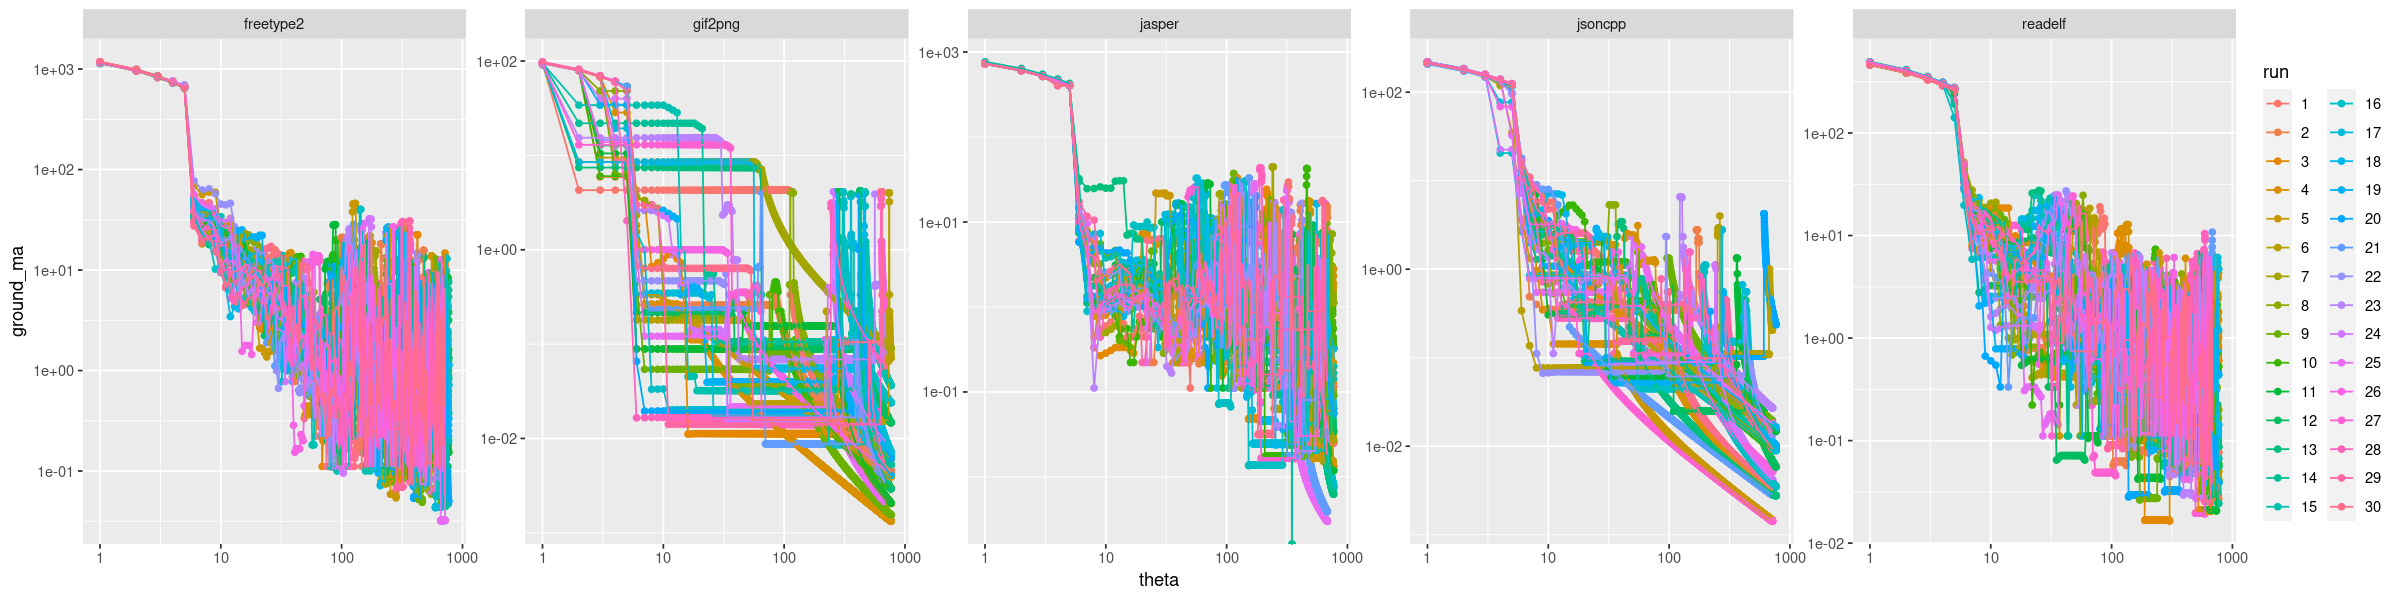

In [7]:
# Function to smooth the empirical coverage rates to obtain ground truth
moving_average = function(x, n = 5) {
    ret = c()
    for (i in 1:length(x)) {
        min_idx = max(1, i - n + 1)
        max_idx = min(length(x), i + n - 1)
        if (sum(x[min_idx:i]) == 0) {
            # find closest non-zero value
            if (min_idx - 1 >= 1) {
                for (j in seq(min_idx - 1, 1, -1)) {
                    if (x[j] > 0) {
                        min_idx = j
                        break
                    }
                }
            }
        }
        if (sum(x[i:max_idx]) == 0) {
            # find closest non-zero value
            if (max_idx + 1 <= length(x)) {
                for (j in seq(max_idx + 1, length(x))) {
                    if (x[j] > 0) {
                        max_idx = j
                        break
                    }
                }
            }
        }
        ret = c(ret, mean(x[min_idx:max_idx]))
    }
    return (ret)
}

# Compute the ground-truth using smoothen species richness curve
gt_data = gb_data %>%
              group_by(subject,run) %>%
              mutate(smooth_gb = sn_gb) %>%
              ungroup()%>%
              group_by(subject,run,theta) %>%
              summarise(mean_sn=mean(smooth_gb),) %>%
              arrange(theta) %>%
              mutate(ground = c(NA, diff(mean_sn))) %>%
              mutate(ground_ma=c(NA,moving_average(diff(mean_sn)))) %>%
              ungroup()

# Plot ground truth
options(repr.plot.width = 20, repr.plot.height = 5)
gt_data %>%
ggplot() +
geom_point(aes(theta,ground_ma,color=run)) + 
geom_line(aes(theta,ground_ma,color=run)) +
scale_x_log10() +
scale_y_log10() +
facet_wrap(~subject,ncol=5,scales="free")

### Showcase extrapolation performance

A comparison between the mean squared error (MSE) of our extrapolator and existing extrapolator. We make predictions at verious points *theta0* for different horizons *m*.

In [8]:
## Showcase an extrapolation scenario for a given subject
selected_sub = "freetype2"
selected_t0 = 250
                            
train_df = train_data %>% filter(subject==selected_sub) %>% filter(theta0<=selected_t0) %>% 
                    mutate(train_limit=exp(seq(log(min(theta)),
                                      log(max(theta0)),length=11))[(10*(1-bet)+1)]) %>% 
                    filter(theta>=train_limit) %>% 
                    group_by(run) %>% 
                    mutate(keep=ifelse((selected_t0-max(theta))>5,0,1)) %>%
                    filter(keep==1)

extra_df = extrapolated %>% filter(subject==selected_sub) %>% 
                    filter(theta0<=selected_t0) %>% filter(theta0==max(theta0)) %>% 
                    filter(prop==1) %>% 
                    filter(run %in% unique(train_df$run))

bb_df = bb_data %>% filter(subject==selected_sub) %>% filter(theta0<=selected_t0) %>%  
                    filter(run %in% unique(train_df$run))

gb_df = gb_data %>% filter(subject==selected_sub) %>% 
                    filter(run %in% unique(train_df$run))


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


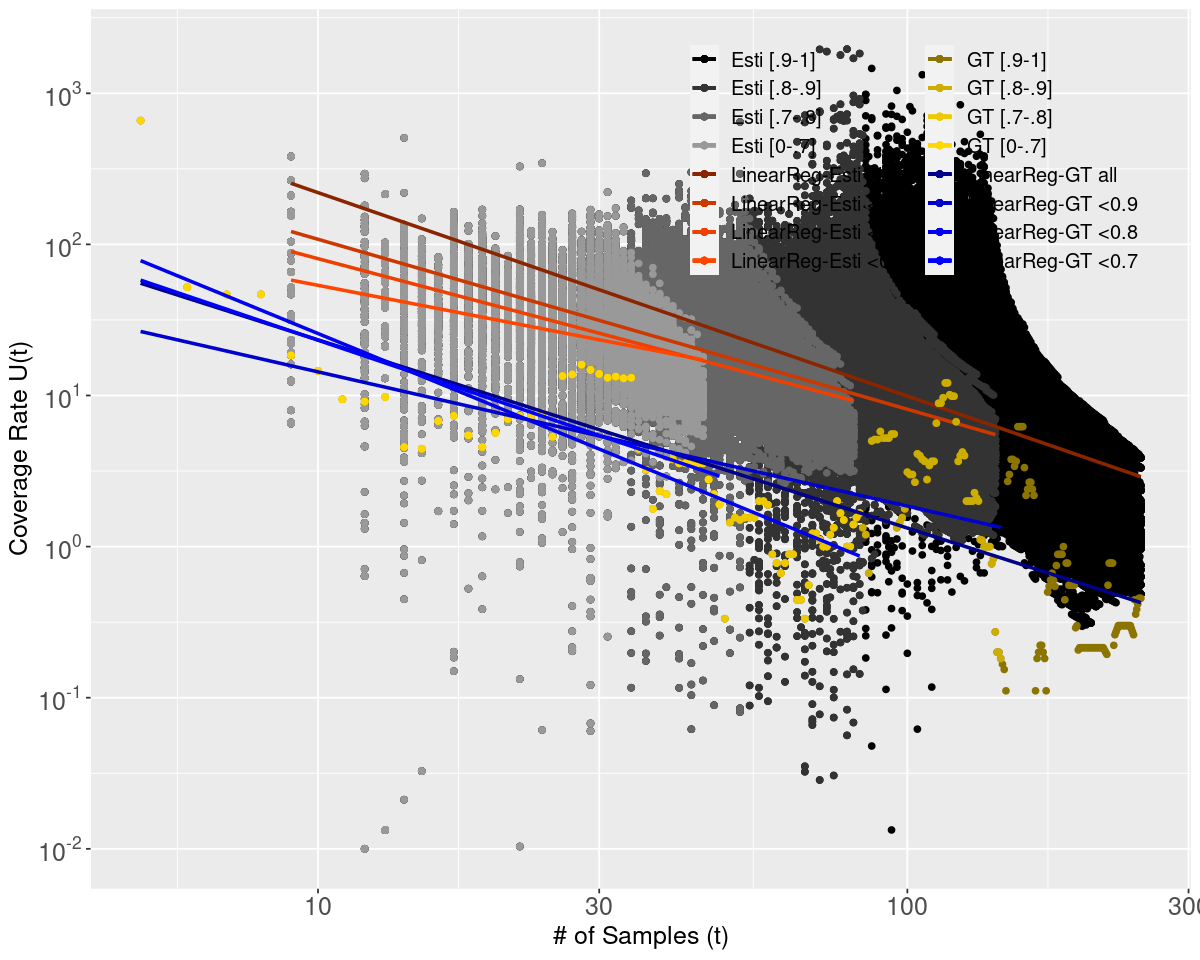

In [9]:
selected_run = 1
threshs = ceiling(exp((log(max(bb_df$theta)) / 10) * 1:10))

# Filter ground truth for the required trial
gt_df = gt_data %>%
    filter(subject == selected_sub) %>%
    filter(run == selected_run)

options(repr.plot.width = 10, repr.plot.height = 8)
plt = ggplot() +
    geom_point(data = bb_df, aes(theta, gt, color = "Esti [.9-1]")) +
    geom_point(data = (bb_df %>% filter(theta0 <= threshs[9])), aes(theta, gt, color = "Esti [.8-.9]")) +
    geom_point(data = (bb_df %>% filter(theta0 <= threshs[8])), aes(theta, gt, color = "Esti [.7-.8]")) +
    geom_point(data = (bb_df %>% filter(theta0 <= threshs[7])), aes(theta, gt, color = "Esti [0-.7]")) +
    geom_smooth(data = bb_df, aes(theta, gt, color = "LinearReg-Esti all"), method = "lm", se = FALSE) +
    geom_smooth(data = (bb_df %>% filter(theta0 <= threshs[9])), aes(theta, gt, color = "LinearReg-Esti <0.9"), 
                method = "lm", se = FALSE) +
    geom_smooth(data = (bb_df %>% filter(theta0 <= threshs[8])), aes(theta, gt, color = "LinearReg-Esti <0.8"), 
                method = "lm", se = FALSE) +
    geom_smooth(data = (bb_df %>% filter(theta0 <= threshs[7])), aes(theta, gt, color = "LinearReg-Esti <0.7"), 
                method = "lm", se = FALSE) +
    geom_point(data = gt_df, aes(theta, ground_ma, color = "GT [.9-1]")) +
    geom_point(data = (gt_df %>% filter(theta <= threshs[9])), aes(theta, ground_ma, color = "GT [.8-.9]")) +
    geom_point(data = (gt_df %>% filter(theta <= threshs[8])), aes(theta, ground_ma, color = "GT [.7-.8]")) +
    geom_point(data = (gt_df %>% filter(theta <= threshs[7])), aes(theta, ground_ma, color = "GT [0-.7]")) +
    geom_smooth(data = gt_df, aes(theta, ground_ma, color = "LinearReg-GT all"), method = "lm", se = FALSE) +
    geom_smooth(data = (gt_df %>% filter(theta <= threshs[9])), aes(theta, ground_ma, color = "LinearReg-GT <0.9"), 
                method = "lm", se = FALSE) +
    geom_smooth(data = (gt_df %>% filter(theta <= threshs[8])), aes(theta, ground_ma, color = "LinearReg-GT <0.8"), 
                method = "lm", se = FALSE) +
    geom_smooth(data = (gt_df %>% filter(theta <= threshs[7])), aes(theta, ground_ma, color = "LinearReg-GT <0.7"), 
                method = "lm", se = FALSE) +
    scale_color_manual("",
        breaks = c(
            "Esti [.9-1]", "Esti [.8-.9]", "Esti [.7-.8]", "Esti [0-.7]", "LinearReg-Esti all", 
            "LinearReg-Esti <0.9", "LinearReg-Esti <0.8", "LinearReg-Esti <0.7",
            "GT [.9-1]", "GT [.8-.9]", "GT [.7-.8]", "GT [0-.7]", "LinearReg-GT all", "LinearReg-GT <0.9", 
            "LinearReg-GT <0.8", "LinearReg-GT <0.7"
        ),
        values = c(
            "black", "grey20", "grey40", "grey60", "orangered4", "orangered3", "orangered2", "orangered1",
            "gold4", "gold3", "gold2", "gold1", "blue4", "blue3", "blue2", "blue1"
        )
    ) +
    theme(
        axis.text.x = element_text(size = 15), axis.text.y = element_text(size = 15), 
        legend.text = element_text(size = 12),
        axis.title.y = element_text(size = 15), legend.title = element_text(size = 15),
        plot.caption = element_text(hjust = 0.5), axis.title.x = element_text(size = 15),
        strip.text.x = element_blank(), strip.text.y = element_text(size = 15)
    ) +
    scale_x_log10("# of Samples (t)", limit = c(5, max(bb_df$theta))) +
    scale_y_log10("Coverage Rate U(t)",
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))
    ) +
    # legend
    theme(legend.position = c(0.75, 0.85), legend.background = element_rect(fill = "transparent", color = NA)) +
    guides(color = guide_legend(ncol = 2))

g = grid.arrange(plt, nrow = 1)
ggsave(file="../figures/Figure-2.png",g,width = 10, height = 8, units = "in", device='png')

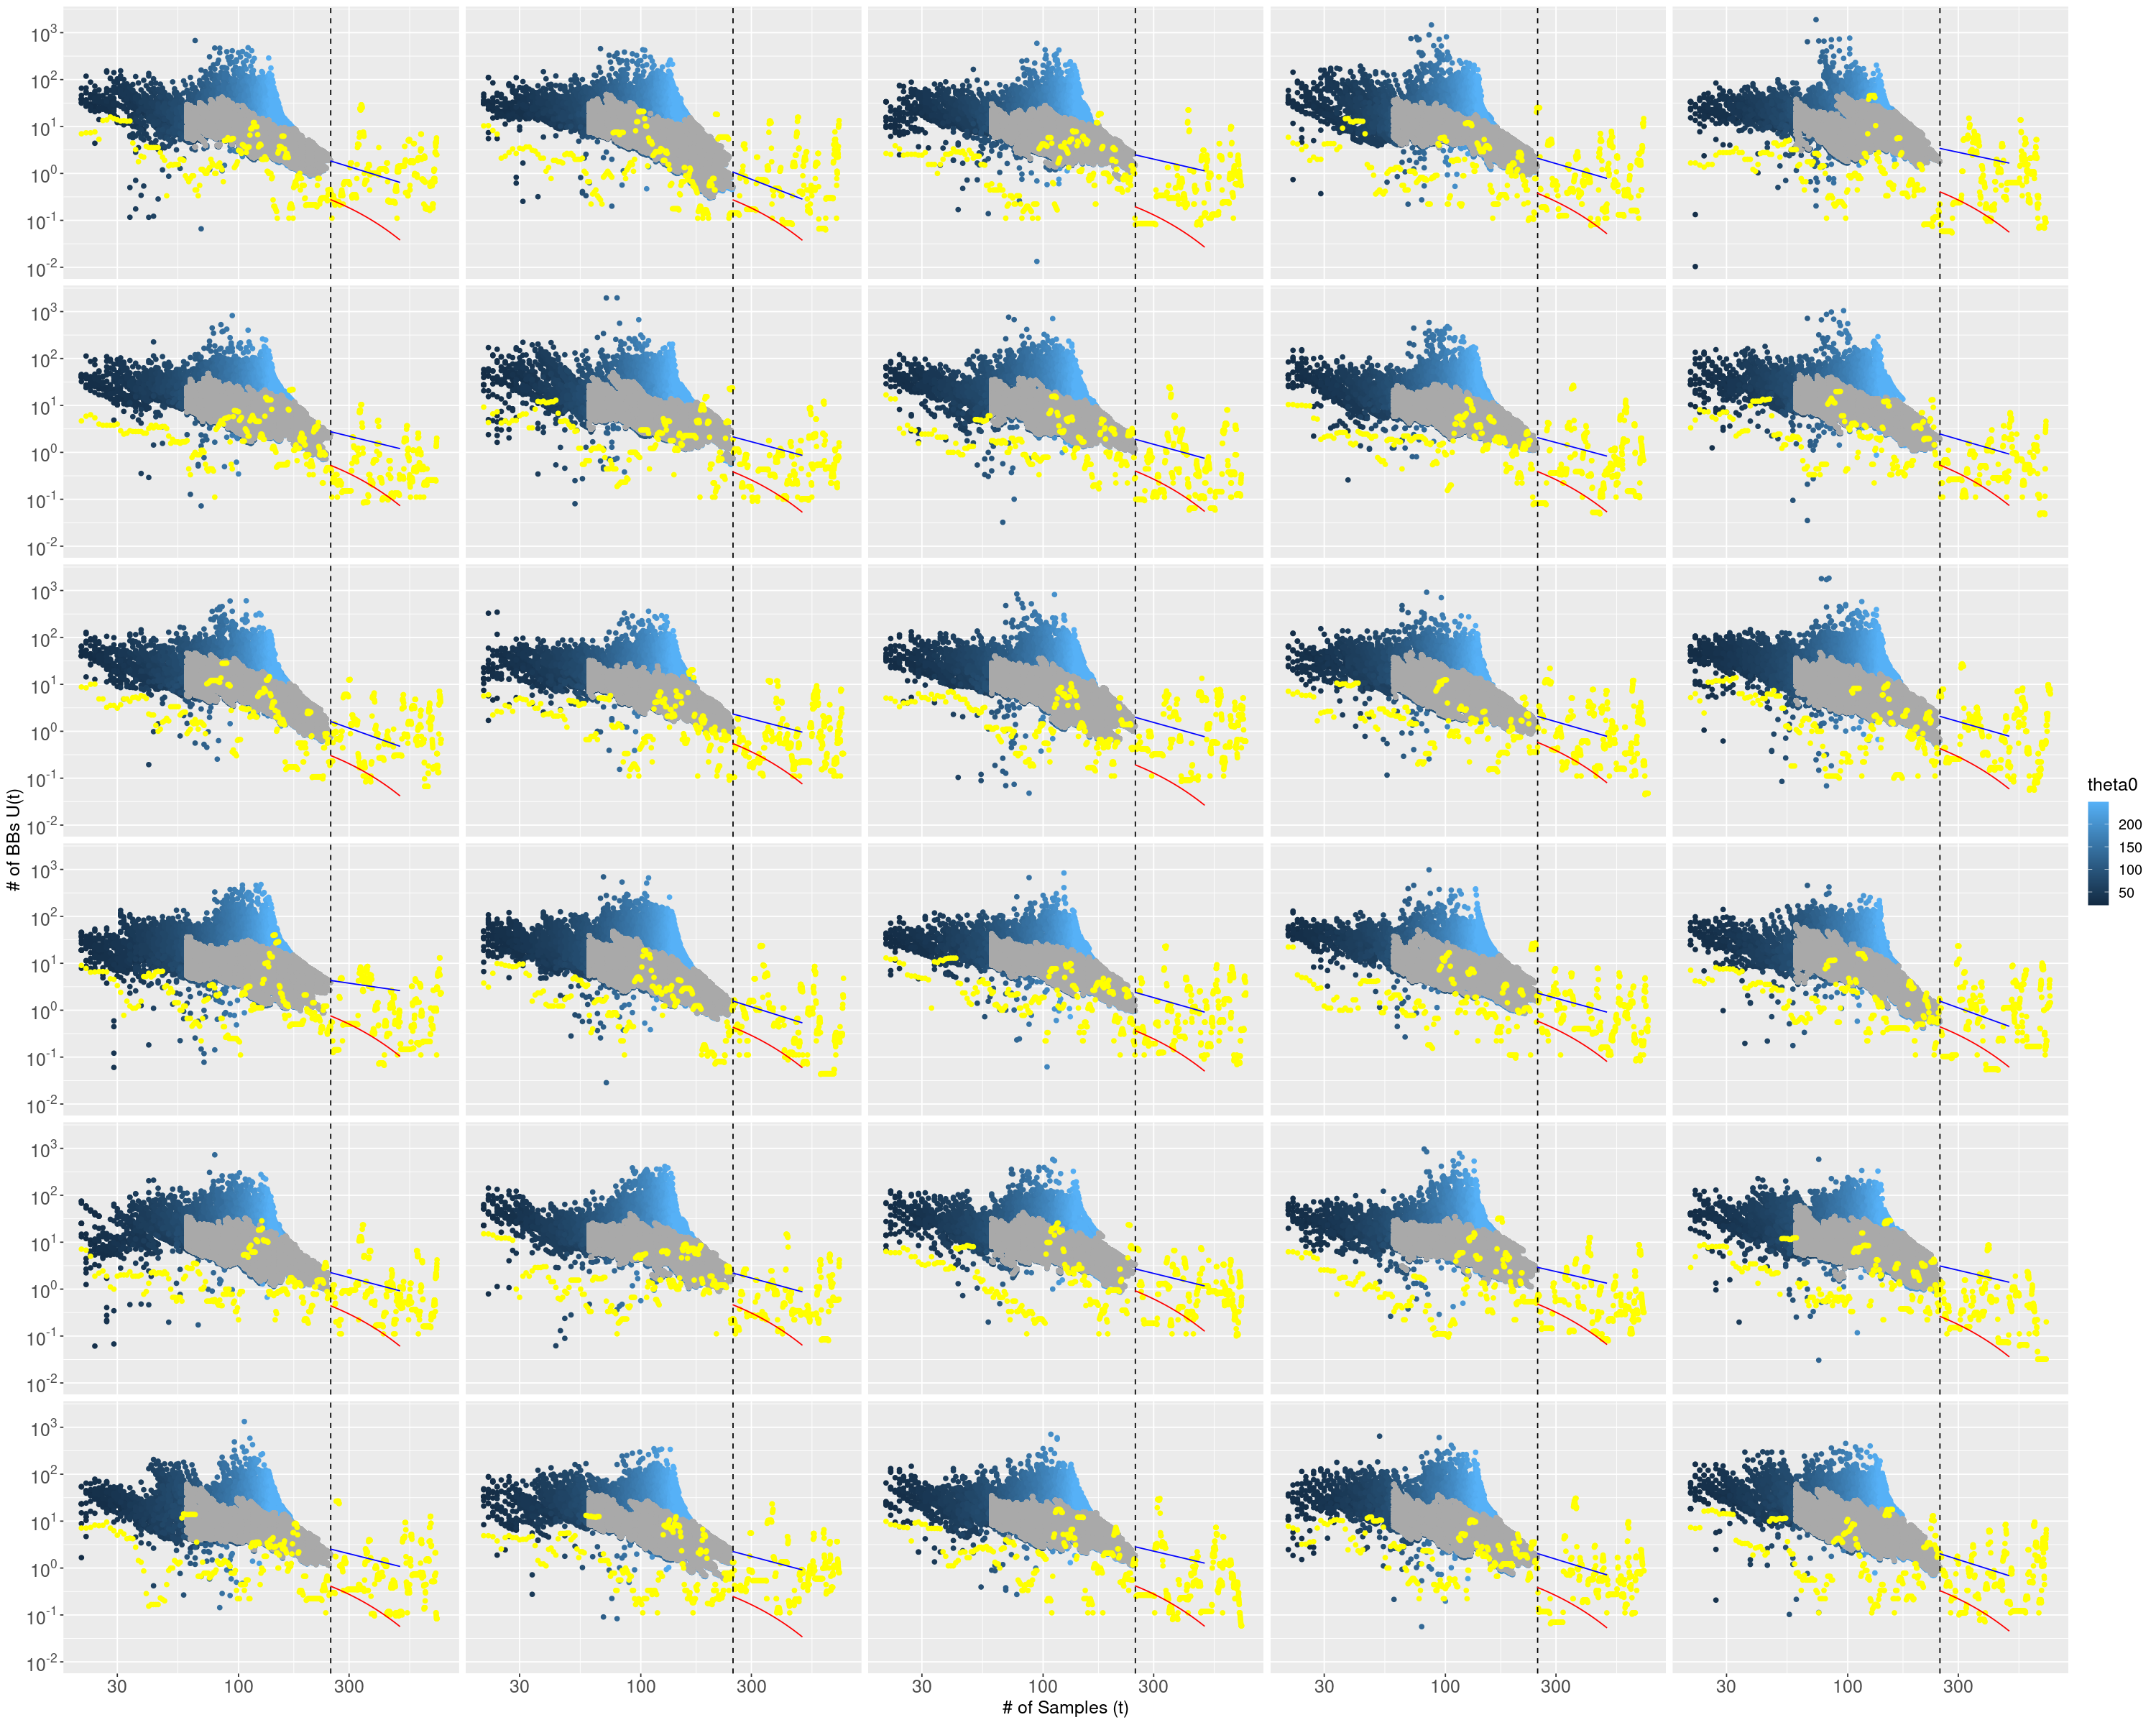

In [10]:
options(repr.plot.width = 25, repr.plot.height = 20)
plt = ggplot() +
    geom_point(data=bb_df %>% filter(theta>20,theta>=round(theta0*bet)),aes(theta,gt,color=theta0)) +
    geom_point(data=train_df %>% filter(theta>20),aes(theta,gt),color="darkgrey") +
    geom_point(data=gt_data %>% filter(theta>20,subject==selected_sub,theta<(3*selected_t0))
                       ,aes(theta,ground_ma),color="yellow") +
    geom_vline(xintercept=selected_t0,linetype="dashed") +
    geom_line(data=extra_df %>% filter(theta>20),aes(theta,delta_new),color="blue") +
    geom_line(data=extra_df %>% filter(theta>20),aes(theta,delta_existing),color="red") +
    theme(axis.text.x=element_text(size=15),axis.text.y=element_text(size=15),legend.text=element_text(size=12),
          axis.title.y=element_text(size=15),legend.title=element_text(size=15),
          plot.caption = element_text(hjust=0.5),axis.title.x=element_text(size=15),
          strip.text.x = element_blank(),strip.text.y = element_text(size=15)) +
    scale_x_log10("# of Samples (t)") +
    scale_y_log10("# of BBs U(t)",
    breaks = trans_breaks("log10", function(x) 10^x),
    labels = trans_format("log10", math_format(10^.x))) +
    facet_wrap(.~run,ncol=5)
                
g = grid.arrange(plt, nrow = 1)
ggsave(file="../figures/Extrapolate_showcase.png",g,width = 25, height = 20, units = "in", device='png')

### RQ 1 - Extrapolator Performance Evaluation

In [11]:
## Compute Mean Squared Error
mse_result = extrapolated %>%
            filter(theta0>=100) %>%
            merge(gt_data,by=c("subject","run","theta"),all.x=TRUE) %>%
            mutate(delta_existing=log(delta_existing),delta_new=log(delta_new),ground=log(ground_ma)) %>%
            group_by(subject,run,theta0,prop) %>%
            summarize(mse_existing=mean((delta_existing-ground)^2),mse_new=mean((delta_new-ground)^2), 
                      .groups = "drop") %>%
            ungroup()

mse_result = mse_result %>%
                filter(theta0<max(theta0)) %>%
                filter((theta0+prop*theta0)<=max(theta0)) %>%
                group_by(subject,run,theta0,prop) %>%
                pivot_longer(!c(subject,run,theta0,prop),names_to = "method", values_to = "value") %>%
                ungroup()

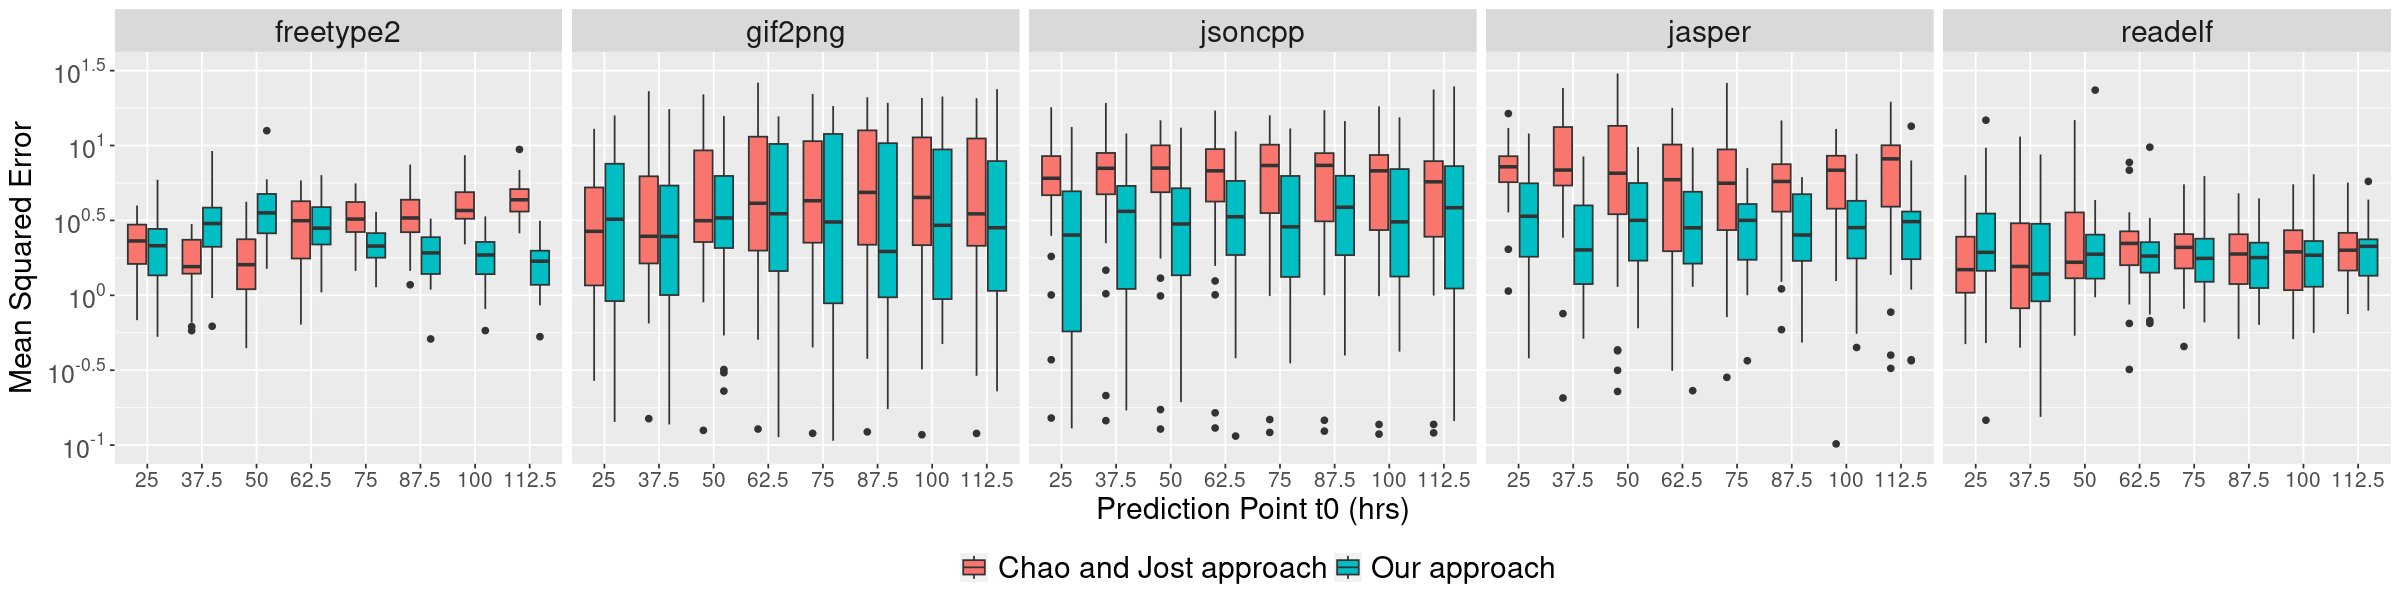

In [12]:
selected_prop = 0.5

mse_result_prop = mse_result %>%
                 filter(prop==selected_prop)

options(repr.plot.width = 20, repr.plot.height = 5)
p1 = mse_result_prop %>%
    filter(method=="mse_existing" | method=="mse_new") %>%
    mutate(method=ifelse(method=="mse_existing","Chao and Jost approach","Our approach")) %>%
    mutate(theta0=as.factor(theta0*(1/4))) %>%
    ggplot() +
    geom_boxplot(aes(x=theta0,y=value,fill=method)) +
    theme(axis.title.x = element_text(size=18), legend.title = element_blank(),legend.position = "bottom",
    legend.text=element_text(size=18),
    axis.text.x=element_text(size=12.5),
    axis.text.y=element_text(size=15),axis.title.y=element_text(size=18),
    strip.text.x = element_text(size=18),strip.text.y = element_text(size=18)) +
    scale_y_log10("Mean Squared Error",
    breaks = trans_breaks("log10", function(x) 10^x),
    labels = trans_format("log10", math_format(10^.x)),limits=c(10^(-1),10^(1.5))) + 
    facet_grid(~subject,scales="free") +
    xlab("Prediction Point t0 (hrs)")
                  
plot_grid(p1, ncol = 1, align = "v")
ggsave("../figures/Figure-4.pdf",width=20,height=5)

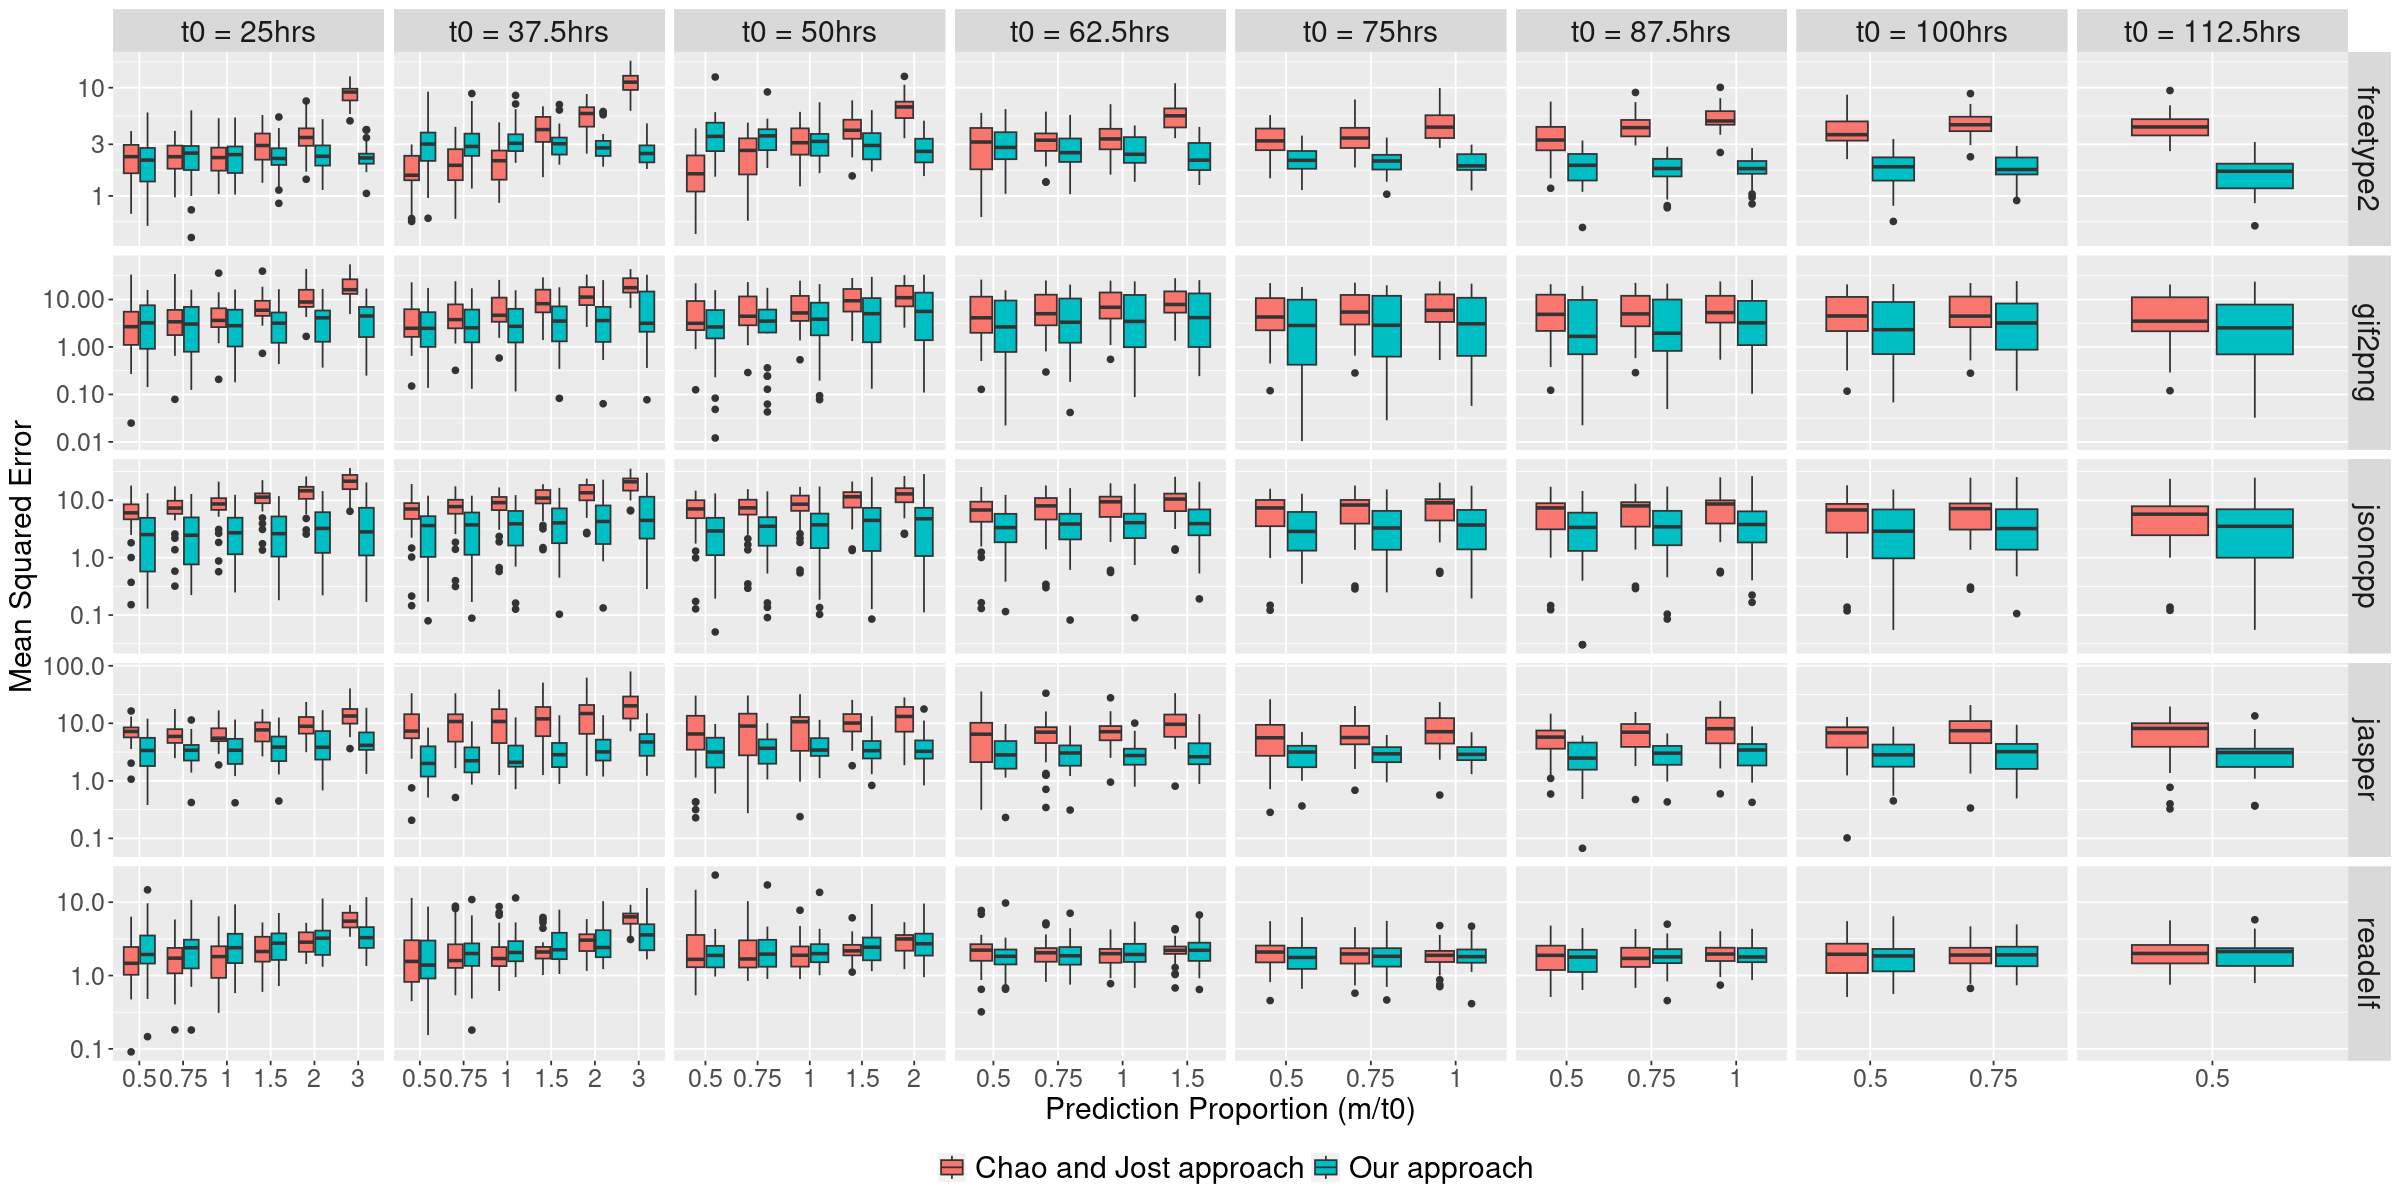

In [13]:
options(repr.plot.width = 20, repr.plot.height = 10)

p1 = mse_result %>%
        filter(method=="mse_existing" | method=="mse_new") %>%
        mutate(method=ifelse(method=="mse_existing","Chao and Jost approach","Our approach")) %>%
        arrange(theta0) %>%
        mutate(theta0=as.factor(theta0*(1/4))) %>%
        mutate(prop=factor(prop),theta0=factor(paste("t0 = ",theta0,"hrs",sep=""),
                                               c(paste("t0 = ",seq(50,500,by=50)*(1/4),"hrs",sep="")))) %>%
        ggplot() +
        geom_boxplot(aes(x=prop,y=value,fill=method)) +
        labs(x="Prediction Proportion (m/t0)") +
        theme(legend.title = element_blank(),legend.position = "bottom",
         axis.text.x=element_text(size=15),axis.title.x=element_text(size=18),
         axis.text.y=element_text(size=15),axis.title.y=element_text(size=18),
         legend.text=element_text(size=18),
         strip.text.x = element_text(size=18),strip.text.y = element_text(size=18)) +
        scale_y_log10("Mean Squared Error") +
        facet_grid(subject~theta0,scales="free")

plot_grid(p1, ncol = 1, align = "v")
ggsave("../figures/Figure-5.pdf",width=20,height=15)

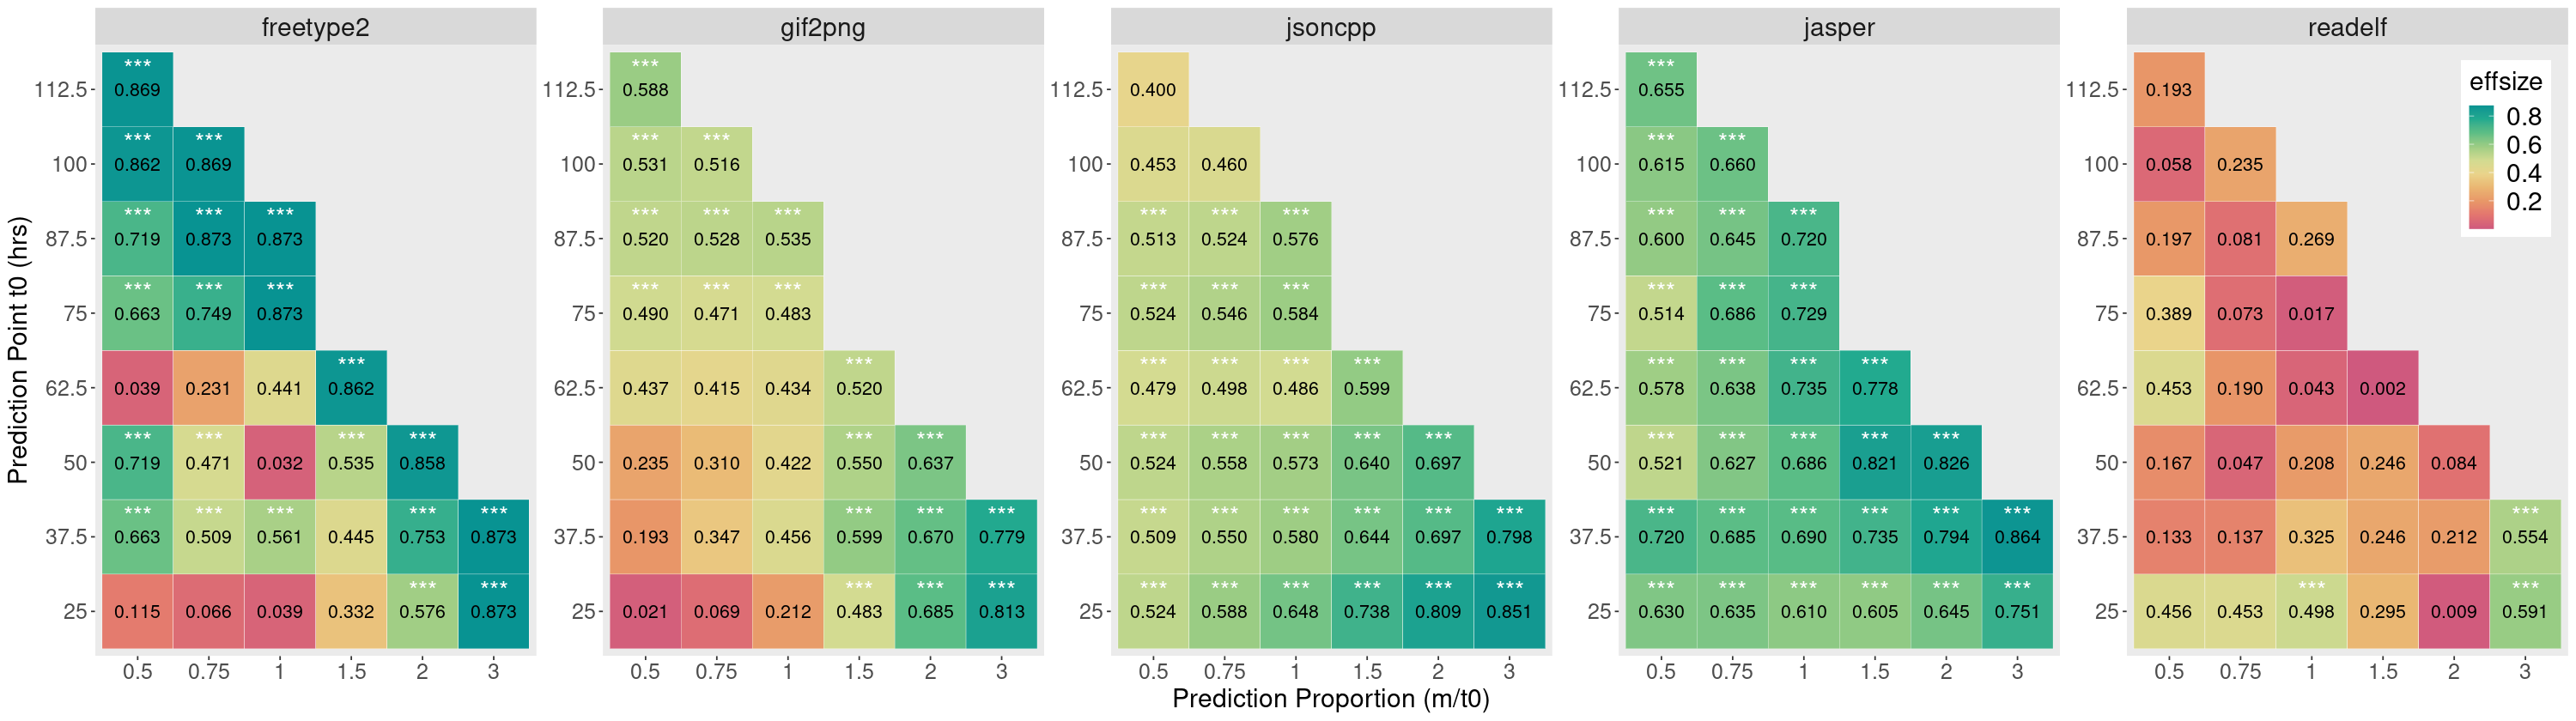

In [14]:
# Heat map
ALTERNATE = "two.sided"
eff_size = merge(
            mse_result %>% 
            filter(method=="mse_existing" | method=="mse_new") %>%
            filter_all(all_vars(!is.infinite(.))) %>%
            drop_na() %>%
            distinct() %>%
            group_by(subject,run,theta0,prop) %>%
            mutate(freq=n()) %>%
            filter(freq==2) %>%
            ungroup() %>%
            group_by(subject,theta0,prop) %>%
            wilcox_effsize(value ~ method,alternate=ALTERNATE,paired=TRUE,conf.level=0.99) %>%
            ungroup() %>%
            select(subject,theta0,prop,effsize),
            mse_result %>% 
            filter(method=="mse_existing" | method=="mse_new") %>%
            filter_all(all_vars(!is.infinite(.))) %>%
            drop_na() %>%
            distinct() %>%
            group_by(subject,run,theta0,prop) %>%
            mutate(freq=n()) %>%
            filter(freq==2) %>%
            ungroup() %>%
            group_by(subject,theta0,prop) %>%
            summarise(p.value=wilcox.test(value ~ method,alternative=ALTERNATE,paired=TRUE,conf.level=0.99)$p.value, 
                      .groups = "drop") %>%
            ungroup(),
            by=c("subject","theta0","prop"))

eff_size = eff_size %>% mutate(theta0=factor(theta0*(1/4)))

eff_size$theta0 = factor(eff_size$theta0, levels=seq(50,max(gb_data$theta),by=50)*(1/4))
eff_size$prop = factor(eff_size$prop, levels=c(0.5,0.75,1,1.5,2,3))

options(repr.plot.width = 25, repr.plot.height = 7)
pp = eff_size %>%
    rename(t0=theta0,proportion=prop) %>%
    ggplot(aes(x = proportion, y = t0, fill = effsize)) +
    geom_tile(color="white") +
    geom_text(aes(label = format(effsize, scientific = FALSE, digits = 1)), color = "black", size = 4.5) +
    geom_text(aes(label = ifelse(p.value<=0.01,"***","")), color = "white", size = 6, vjust = -0.7) +
    scale_fill_gradientn(colors = hcl.colors(10, "Temps", rev = TRUE)) +
    theme(panel.border = element_blank(), panel.grid.major = element_blank(),panel.grid.minor = element_blank(),
         axis.text.x=element_text(size=15),strip.text.x = element_text(size=18),
         axis.title.x=element_text(size=18),strip.text.y = element_text(size=18),
         axis.text.y=element_text(size=15),
         axis.title.y=element_text(size=18),
         legend.text=element_text(size=18),
         legend.title=element_text(size=18),legend.position=c(0.975,0.83)) +
    xlab("Prediction Proportion (m/t0)") + 
    ylab("Prediction Point t0 (hrs)") +
    facet_wrap(~subject,scales="free",nrow=1)

g = grid.arrange(pp, nrow = 1)
ggsave("../figures/Figure-6.pdf",g,width=25,height=7)

### RQ 2 - Sensitivity Analysis

As we answer our RQ2 in the paper, we investigate the impact of the ***alpha*** and ***beta** parameters in our extrapolation algorithm. We choose one prediction point (t0=75hrs) and a single prediction horizon (m=1).

In [15]:
if(REGENERATE_DATA){
    
    subjects = list.files("../data/fuzztastic_data/")
    
    RESET = TRUE
    sub1 = 1
    sub2 = 1
    n_reps = 1
    for(subject in subjects){
        folder = paste("../data/fuzztastic_data/",subject,"/","seed_01",sep="")
        for(file_run in list.files(folder)){
            data = tibble()
            subject = subject
            run = str_sub(file_run,-2)
            timestamps = c()
            n_list = c()
            sn_list = c()
            f1_list = c()
            f2_list = c()
            u_list = c()
            for(file in list.files(paste(folder,"/",file_run,sep=""))){
                ## Prepare the hit count table using all the available data
                bb_cov = as.data.frame(fromJSON(paste(folder,"/",file_run,"/",file,sep="")))
                bb_cov = bb_cov %>% mutate(block_coverage = ifelse(block_coverage>=8,block_coverage-8,block_coverage)) 
                temp = t(as.data.frame(bb_cov$block_coverage))
                colnames(temp) = 1:length(bb_cov$block_coverage)
                row.names(temp) = NULL
                temp = as.data.frame(temp)
                timestamps = c(timestamps,as.integer(substr(str_split(file,"_")[[1]][3],1,10)))
                n_list = c(n_list,max(bb_cov$block_coverage))
                sn_list = c(sn_list,sum((bb_cov$block_coverage)>0))
                data = rbind(data,temp)
            }
            bb_ids = 1:length(bb_cov$block_coverage)
            transformed = data %>% summarise(across(1:length(bb_ids),function(x) cumsum(c(0,ifelse(diff(x)>0,1,0)))))
            f1_list = apply(transformed,1,function(x) sum(as.numeric(unlist(x))==1))
            f2_list = apply(transformed,1,function(x) sum(as.numeric(unlist(x))==2))
            u_list = rowSums(transformed)
            gb_df = tibble(subject=subject,run=run,timestamp=timestamps,n=n_list,theta=0:length(n_list[-1]),
                           u=u_list,f1=f1_list,f2=f2_list,sn_gb=sn_list)
            ## Write gb_data
            if(sub1==1){
               write.table(gb_df, file = "../data/gb_data_sensitivity.csv", row.names = FALSE,quote = FALSE)  
               sub1 = sub1 + 1
            }else{
               write.table(gb_df, file = "../data/gb_data_sensitivity.csv",
                append = TRUE, quote = FALSE,
                col.names = FALSE, row.names = FALSE)
            }
            
            transformed = data %>% summarise(across(1:length(bb_ids),function(x) ifelse(diff(x)>0,1,0)))
            timestamps = timestamps[-1]
            n_list = n_list[-1]
            u_list = u_list[-1]
            sn_list = sn_list[-1]
            f1_list = f1_list[-1]
            f2_list = f2_list[-1]
            
            alpha_list = c(1,0.7,0.5,0.3)
            for(rep in 1:n_reps){
                for(m in seq(1,length(u_list),4)){
                    dis_prob = tibble()
                    cores = 8 #detectCores()
                    cl = makeCluster(cores[1]-1,type = "FORK")
                    registerDoParallel(cl)
                    ## Shuffling algorithm (difference, shuffle, reconstitute) for selected theta0
                    ## Do the estimates for all X = theta0-k where 0<k<theta0 after the shuffling algorithm
                    ## To get more estimates, repeat this several times (i.e. # of repetitions)
                    dis_prob = foreach(alp=alpha_list, .combine='rbind', .packages=c("dplyr", "tidyverse")) %dopar% {
                       filtered = transformed %>% mutate(theta=1:n()) %>% filter(theta<=m)
                       if(RESET){
                           cut_pt = round(exp(seq(log(1),log(m),length=11))[(10*(1-alp)+1)])
                           filtered = filtered %>% filter(theta>=cut_pt)
                       }else{
                           cut_pt = 0
                       }
                       theta_list = filtered$theta
                       filtered = filtered %>% select(-theta)
                       shuffle_order = sample(1:nrow(filtered),nrow(filtered))
                       filtered = filtered[shuffle_order,]
                       filtered = filtered %>% summarise(across(1:length(bb_ids),cumsum))
                       f1 = apply(filtered,1,function(x) sum(as.numeric(unlist(x))==1))
                       f2 = apply(filtered,1,function(x) sum(as.numeric(unlist(x))==2))
                       sn = apply(filtered,1,function(x) sum(as.numeric(unlist(x))>0))
                       rm(list = c("filtered"))
                       tibble(subject=subject,alpha=alp,run=run,repetition=rep,timestamp=timestamps[m],
                              time=timestamps[cut_pt:m],n0=n_list[m],n=n_list[cut_pt:m],theta=theta_list,
                              start=cut_pt,theta0=m,f1=f1+1,f2=f2+1,
                              gt=(f1/(theta-start))*(((theta-start-1)*f1)/((theta-start-1)*f1+(2*f2))),
                              sn=sn,s=length(bb_ids))
                    }
                    
                    if(sub2==1){
                        write.table(dis_prob, file = "../data/bb_data_sensitivity.csv", row.names = FALSE,
                                    quote = FALSE)
                        sub2 = sub2 + 1
                    }else{
                        write.table(dis_prob, file = "../data/bb_data_sensitivity.csv",
                        append = TRUE, quote = FALSE,
                        col.names = FALSE, row.names = FALSE)
                    }
                    stopCluster(cl)
                    gc()
                }
            }
        }
    }
    ## Save gathered data as R objects for future use
    gb_data = read.table("../data/gb_data_sensitivity.csv",header=T)
    gb_data$run = as.factor(gb_data$run)
    
    gb_data = gb_data %>% 
                rename(f1_gb=f1,f2_gb=f2) %>%
                mutate(f1_gb = f1_gb + 1,f2_gb = f2_gb + 1)
    save(gb_data,file="../data/gb_data_sensitivity.Rdata")
    
    bb_data = read.table("../data/bb_data_sensitivity.csv",header=T)
    # Remove infinite values from extrapolated data table
    bb_data = bb_data %>% filter_all(all_vars(!is.infinite(.)))
    bb_data$run = as.factor(bb_data$run)
    
    # Attach greybox data to shuffling data
    bb_data = merge(bb_data,gb_data %>% select(subject,run,timestamp,f1_gb,f2_gb,sn_gb),
                    by=c("subject","run","timestamp"),all.x = TRUE)
    save(bb_data,file="../data/bb_data_sensitivity.Rdata")
} else{
    ## Loading saved data
    load(file="../data/gb_data_sensitivity.Rdata")
    load(file="../data/bb_data_sensitivity.Rdata")
}                       


In [16]:
## Perform Extrapolation
if(REGENERATE_DATA){
    # Initialize parameter ranges
    init = 1
    train_data = tibble()
    t0_list = 300
    subjects = unique(gb_data$subject)
    proportions = c(0.5,0.75,1,1.5,2,3)
    gamma_list = c(1,0.7,0.5,0.3,0.1)
    for(sub in subjects){
        for(trial in unique(bb_data$run)){
            for(gam in gamma_list){
                for(alp in unique(bb_data$alpha)){
                    # Filter required data
                    bb_df = bb_data %>% filter(run==trial) %>% 
                            filter(subject==sub) %>% filter(alpha==alp) %>% filter((theta-start)>=5)
                    gb_df = gb_data %>% filter(run==trial) %>% filter(subject==sub)
                    for(t0 in t0_list){
                        
                        ######################################
                        reg_df = bb_df %>% filter(theta0<=t0)
                        
                        tryCatch({
                        # Only to get most recent points as training
                        train_limit = exp(seq(log(min((reg_df %>% filter(theta>0))$theta)),
                                  log(max((reg_df %>% filter(theta>0))$theta0)),length=11))[(10*(1-gam)+1)]
                        reg_df = reg_df %>% arrange(theta) %>% filter(theta>=train_limit)
                
                        reg_df[is.na(reg_df) | reg_df == "Inf"] = NA
                        #reg_df = reg_df %>% mutate(gt=replace(gt,gt==0,NA))
                        reg_df = reg_df %>% drop_na()
                        model = lm(log(gt)~log(theta),data = reg_df)
                        slope = model$coefficient[2]
                        intercept = model$coefficient[1]
                        
                        ######################################
                        predict_df = (gb_df %>% arrange(theta) %>% filter(theta>=max(reg_df$theta)))
                        f1_gb = predict_df$f1_gb[1]
                        f2_gb = predict_df$f2_gb[1]
                        theta0 = predict_df$theta[1]
                        extra_df = tibble()
                        for(prop in proportions){
                            m = round(prop*t0)
                            if(nrow(predict_df)<m){
                            m = nrow(predict_df)
                            }
                            delta_new=as.numeric(lapply(1:m, function(x) exp((slope*log(theta0+x)+intercept))))
                                                        
                            extra_df = rbind(extra_df,
                                             tibble(subject=sub,alpha=alp,gamma=gam,run=trial,theta0=t0,prop=prop,
                                                    theta=seq(max(reg_df$theta),length=m),
                                                    delta_new=delta_new,sn_gb=predict_df$sn_gb[1:m]))
                                    
                        }
                                                 
                        if(init==1){
                           write.table(extra_df, file = "../data/extrapolated_sensitivity.csv", row.names = FALSE,
                                       quote = FALSE)
                           init = init + 1
                        }else{
                           write.table(extra_df, file = "../data/extrapolated_sensitivity.csv",
                           append = TRUE, quote = FALSE,
                           col.names = FALSE, row.names = FALSE)
                        }
                        
                        }, error=function(e){})
                    }
                }
            } 
        }
    }

    ## Save gathered data as R objects for future use
    extrapolated = read.table("../data/extrapolated_sensitivity.csv",header=T)
    save(extrapolated,file="../data/extrapolated_sensitivity.Rdata")
}else{
    ## Loading saved data
    load(file="../data/extrapolated_sensitivity.Rdata")
}

In [17]:
# Moving average function to compute ground-truth
moving_average = function(x, n = 5) {
    ret = c()
    for (i in 1:length(x)) {
        min_idx = max(1, i - n + 1)
        max_idx = min(length(x), i + n - 1)
        if (sum(x[min_idx:i]) == 0) {
            # find closest non-zero value
            if (min_idx - 1 >= 1) {
                for (j in seq(min_idx - 1, 1, -1)) {
                    if (x[j] > 0) {
                        min_idx = j
                        break
                    }
                }
            }
        }
        if (sum(x[i:max_idx]) == 0) {
            # find closest non-zero value
            if (max_idx + 1 <= length(x)) {
                for (j in seq(max_idx + 1, length(x))) {
                    if (x[j] > 0) {
                        max_idx = j
                        break
                    }
                }
            }
        }
        ret = c(ret, mean(x[min_idx:max_idx]))
    }
    return (ret)
}

# Compute the ground-truth using smoothen species richness curve
gt_data = gb_data %>%
              group_by(subject,run) %>%
              mutate(smooth_gb = sn_gb) %>% #predict(loess(sn_gb ~ theta, span=0.05))
              ungroup()%>%
              group_by(subject,run,theta) %>%
              summarise(mean_sn=mean(smooth_gb),) %>%
              arrange(theta) %>%
              mutate(ground=c(NA,diff(mean_sn))) %>%
              mutate(ground_ma=c(NA,moving_average(diff(mean_sn)))) %>%
              ungroup()


`summarise()` has grouped output by 'subject', 'run'. You can override using
the `.groups` argument.


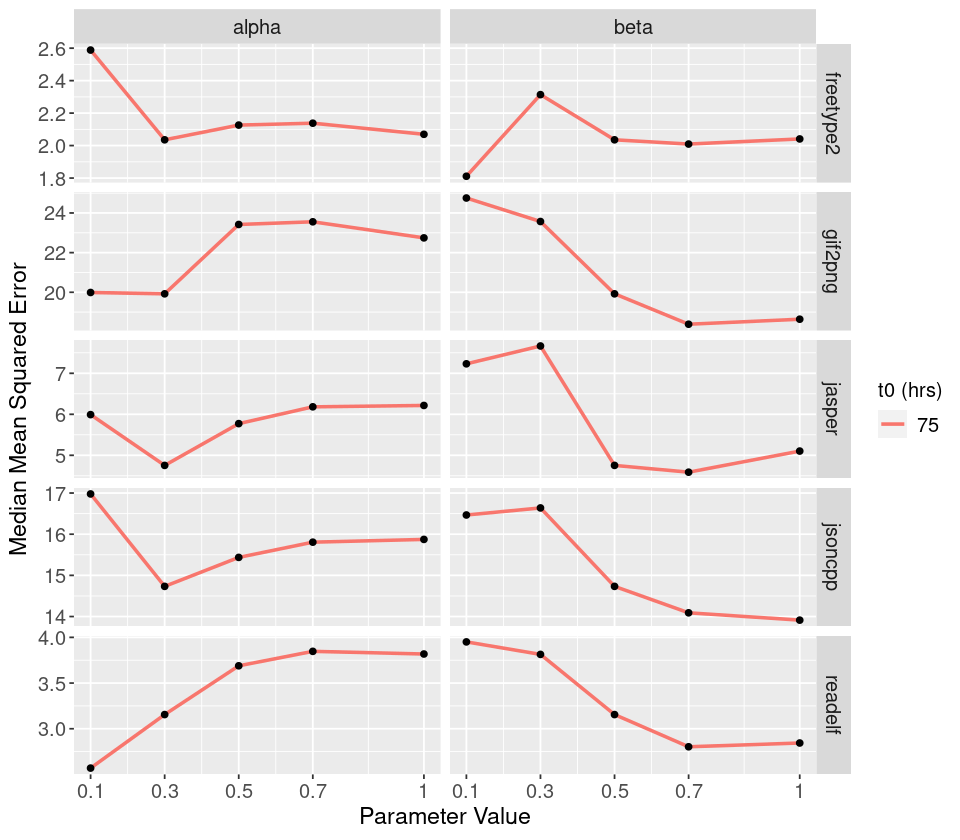

In [18]:
## Compute Mean Squared Error
mse_result = extrapolated %>%
            filter(theta0>=100) %>%
            merge(gt_data,by=c("subject","run","theta"),all.x=TRUE) %>%
            mutate(delta_new=log(delta_new),ground=log(ground_ma)) %>%
            group_by(subject,run,theta0,alpha,gamma,prop) %>%
            summarize(mse_new=mean((delta_new-ground)^2), .groups = "drop") %>%
            ungroup()

mse_result = mse_result %>%
                group_by(subject,run,theta0,alpha,gamma,prop) %>%
                pivot_longer(!c(subject,run,theta0,alpha,gamma,prop),names_to = "method", values_to = "value") %>%
                ungroup()


mse_res = mse_result %>%
        filter(method=="mse_new") %>%
        arrange(theta0) %>%
        mutate(theta0 = theta0*(1/4)) %>% 
        rename(beta=gamma) %>%
        filter(prop==1) %>%
        group_by(subject,theta0,prop,alpha,beta) %>%
        summarize(value = median(value),.groups="drop") %>%
        ungroup()        

p1 = mse_res %>%
        filter(beta==0.5) %>%
        group_by(subject,theta0,prop,alpha) %>%
        summarize(value = median(value),.groups="drop") %>%
        ungroup() %>%
        group_by(subject,theta0,prop) %>%
        pivot_longer(!c(subject,theta0,prop,value),names_to = "parameter", values_to = "param_val")

p2 = mse_res %>%
        filter(alpha==0.3) %>%
        group_by(subject,theta0,prop,beta) %>%
        summarize(value = median(value),.groups="drop") %>%
        ungroup() %>%
        group_by(subject,theta0,prop) %>%
        pivot_longer(!c(subject,theta0,prop,value),names_to = "parameter", values_to = "param_val")

mse_res = rbind(p1,p2)

options(repr.plot.width = 8, repr.plot.height = 7)
pp = mse_res %>%
filter(theta0==75) %>%
  mutate(param_val = as.numeric(as.character(param_val)), theta0 = factor(theta0)) %>%
  ggplot(aes(x = param_val, y = value, color = theta0, group = theta0)) +
  geom_line(size = 1) +
  geom_point(size = 1.5,color="black") +
  facet_grid(subject ~ as.character(parameter), scales = "free_y") +
  labs(x = "Parameter Value", y = "Median Mean Squared Error") +
  theme(legend.title = element_text(size = 12),
        axis.text.x = element_text(size = 12),
        axis.title.x = element_text(size = 14),
        axis.text.y = element_text(size = 12),
        axis.title.y = element_text(size = 14),
        legend.text = element_text(size = 12),
        strip.text = element_text(size = 12),
        strip.text.x = element_text(size = 12)) +
  scale_color_discrete(name = "t0 (hrs)") +
  scale_x_continuous(breaks = c(0.1, 0.3, 0.5, 0.7, 1), labels = c("0.1", "0.3", "0.5", "0.7", "1"))

# Save the plot with the alpha and beta parameters
pp
ggsave(paste("../figures/", "Figure-7", ".pdf", sep = ""), plot = pp, width = 10, height = 7, family = "Helvetica")